In [8]:
import os, sys, math, pickle, time
from zmqRemoteApi import RemoteAPIClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randint as ri
from random import uniform as ru

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

### Funciones

In [9]:
def radian_to_degree(rad):
    return np.degrees(rad)

In [10]:
#Function to split the training data into X,y datasets
def load_dataset_deg(scene_in = "modular02a"):
    # Defining usefull variables
    path = os.getcwd() + "\\training_data\\2023_14_11"
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]


    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)


    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns

    #Converts from rad to degrees the columns
    for column in increments_df.columns:
        increments_df[column] = increments_df[column].apply(radian_to_degree)

    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns

    #Converts from rad to degrees the columns
    for column in prev_j_positions_df.columns:
        prev_j_positions_df[column] = prev_j_positions_df[column].apply(radian_to_degree)

    #Builds the X dataframe
    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")


    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns

    #Converts from rad to degrees the columns
    for column in post_j_positions_df.columns:
        post_j_positions_df[column] = post_j_positions_df[column].apply(radian_to_degree)

    #Builds the y dataframe
    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

In [11]:
#Function to split the training data into X,y datasets
def load_dataset(scene_in = "modular02a"):
    # Defining usefull variables
    path = os.getcwd() + "\\training_data\\2023_14_11"
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]


    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)


    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns


    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns


    #Builds the X dataframe
    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")


    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns


    #Builds the y dataframe
    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

In [12]:
def adapt_X_y(X_a,y_a):
    X_a_cols = ['current_state_x', 'current_state_y', 'current_state_z', 'joint0_current_state_rad', 'joint1_current_state_rad', 'joint0_actions_rad', 'joint1_actions_rad']

    X_a = pd.concat([X_a["prev_pos_x"], X_a["prev_pos_y"] , X_a["prev_pos_z"],
                X_a["prev_j_positions_0"], X_a["prev_j_positions_1"],
                X_a["increments_0"], X_a["increments_1"]], 
                        axis="columns")

    X_a.columns = X_a_cols

    y_a_cols = ['future_state_x', 'future_state_y', 'future_state_z', 'joint0_future_state_rad', 'joint1_future_state_rad']

    y_a = pd.concat([y_a["post_pos_x"], y_a["post_pos_y"] , y_a["post_pos_z"],
                y_a["post_j_positions_0"], y_a["post_j_positions_1"]], 
                        axis="columns")
    y_a.columns = y_a_cols
    return X_a, y_a

In [13]:
def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  #plt.ylim([0,0.1])
  plt.legend()
  plt.show()

In [14]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num], s=1)

        #Getting important values
        minim = min(test.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(test.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,6))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [15]:
def export_model(exp_scene, exp_model, exp_scaler):
    timestr = time.strftime("_%Y_%d_%m")
    models_path = "models\\" + timestr[1:]
    if not os.path.exists(models_path):
        os.mkdir(models_path)
        print(f"Directorio '{models_path}' ha sido creado.")
    else:
        print(f"El directorio '{models_path}' ya existe.")
    exp_model.save(models_path + "\\model_" + exp_scene + timestr + ".keras")
    with open(models_path + "\\scaler_" + exp_scene + timestr + '.pkl', 'wb') as file:
        pickle.dump(exp_scaler, file)

### Modular02a

In [ ]:
scene = "modular02a"
X, y =load_dataset(scene)
X.shape

In [ ]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape,X_test.shape

In [ ]:
y_train.shape,y_test.shape

In [ ]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [ ]:
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

In [ ]:
plot_history(history, "Huber")

In [ ]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num])

        #Getting important values
        minim = min(pred.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(pred.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,3))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [ ]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
df_test_predictions_unscaled = pd.DataFrame(test_predictions_unscaled)

In [ ]:
plot_pred_vs_test(y_test, df_test_predictions_unscaled)

In [ ]:
timestr = time.strftime("_%Y_%d_%m")
model_name = "model_" + scene + timestr + ".keras"
print(model_name)
model.save("models\\" + model_name)

### Modular02b

In [ ]:
scene = "modular02b"
X, y =load_dataset(scene)

# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Creacion y entrenamiento del modelo
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

plot_history(history, "Huber")

## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
df_test_predictions_unscaled = pd.DataFrame(test_predictions_unscaled)

plot_pred_vs_test(y_test, df_test_predictions_unscaled)

In [ ]:
timestr = time.strftime("_%Y_%d_%m")
model_name = "model_" + scene + timestr + ".keras"
print(model_name)
model.save("models\\" + model_name)

### Modular02c

In [ ]:
scene = "modular02c"
X, y =load_dataset(scene)

# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Creacion y entrenamiento del modelo
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

plot_history(history, "Huber")

## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
df_test_predictions_unscaled = pd.DataFrame(test_predictions_unscaled)

plot_pred_vs_test(y_test, df_test_predictions_unscaled)

In [ ]:
timestr = time.strftime("_%Y_%d_%m")
models_path = "models\\" + timestr[1:]
if not os.path.exists(models_path):
    os.mkdir(models_path)
    print(f"Directorio '{models_path}' ha sido creado.")
else:
    print(f"El directorio '{models_path}' ya existe.")
model.save(models_path + "\\model_" + scene + timestr + ".keras")

### Modular 02

In [16]:
scene = "modular02_"
X, y =load_dataset(scene)
X, y = adapt_X_y(X,y)
X

,current_state_x,current_state_y,current_state_z,joint0_current_state_rad,joint1_current_state_rad,joint0_actions_rad,joint1_actions_rad
0,0.085313,0.000005,0.156858,-0.785398,-0.785398,-0.035228,0.008034
1,0.087355,0.000001,0.154454,-0.820785,-0.777326,-0.122511,0.072272
2,0.093529,-0.000013,0.145499,-0.943990,-0.704675,-0.112824,-0.119296
3,0.097128,0.000022,0.131159,-1.057933,-0.824201,-0.096348,-0.091552
4,0.098422,0.000007,0.119065,-1.155711,-0.916394,0.128615,-0.019378
...,...,...,...,...,...,...,...
34995,0.097520,-0.000264,0.090918,-1.348545,-1.462710,0.108797,0.031302
34996,0.099184,-0.000264,0.100637,-1.240552,-1.431434,-0.062875,0.121708
34997,0.102269,-0.000262,0.096705,-1.304426,-1.309168,-0.030965,-0.026722
34998,0.101416,-0.000263,0.093457,-1.336431,-1.335516,-0.059305,-0.127545


In [26]:
y

,future_state_x,future_state_y,future_state_z,joint0_future_state_rad,joint1_future_state_rad
0,0.087355,0.000001,0.154454,-0.820785,-0.777326
1,0.093529,-0.000013,0.145499,-0.943990,-0.704675
2,0.097128,0.000022,0.131159,-1.057933,-0.824201
3,0.098422,0.000007,0.119065,-1.155711,-0.916394
4,0.095416,0.000058,0.130858,-1.027796,-0.936441
...,...,...,...,...,...
34995,0.099184,-0.000264,0.100637,-1.240552,-1.431434
34996,0.102269,-0.000262,0.096705,-1.304426,-1.309168
34997,0.101416,-0.000263,0.093457,-1.336431,-1.335516
34998,0.097182,-0.000258,0.086754,-1.396928,-1.463337


In [14]:
maxim = max(y.iloc[:,-1])
maxim

1.5707967281341553

In [15]:
minim = min(y.iloc[:,-1])
minim

-1.5707976818084717

In [17]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape, y_train.shape

((28000, 7), (28000, 5))

In [28]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape

(28000, 7)

In [29]:
# Creacion y entrenamiento del modelo
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
700/700 [==============================] - 1s 1ms/step - loss: 0.0411 - val_loss: 0.0018
Epoch 2/25
700/700 [==============================] - 1s 1ms/step - loss: 8.0563e-04 - val_loss: 3.7560e-04
Epoch 3/25
700/700 [==============================] - 1s 1ms/step - loss: 2.5883e-04 - val_loss: 1.9600e-04
Epoch 4/25
700/700 [==============================] - 1s 1ms/step - loss: 1.7316e-04 - val_loss: 1.6095e-04
Epoch 5/25
700/700 [==============================] - 1s 1ms/step - loss: 1.3886e-04 - val_loss: 1.2292e-04
Epoch 6/25
700/700 [==============================] - 1s 1ms/step - loss: 1.1925e-04 - val_loss: 1.0642e-04
Epoch 7/25
700/700 [==============================] - 1s 1ms/step - loss: 1.0350e-04 - val_loss: 1.0972e-04
Epoch 8/25
700/700 [==============================] - 1s 1ms/step - loss: 8.7084e-05 - val_loss: 9.5374e-05
Epoch 9/25
700/700 [==============================] - 1s 1ms/step - loss: 7.7164e-05 - val_loss: 6.9305e-05
Epoch 10/25
700/700 [===============

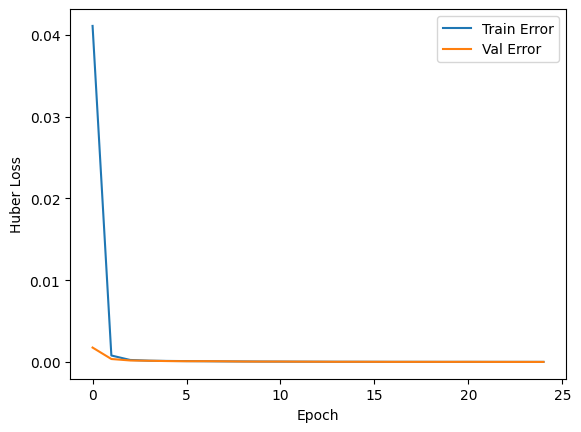

In [30]:
plot_history(history, "Huber")

In [31]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)

219/219 [==============================] - 0s 780us/step


#### Pruebas para limitar las salidas

In [107]:
df_test_predictions = pd.DataFrame(test_predictions)
df_test_predictions_clipped = df_test_predictions
df_test_predictions

,0,1,2,3,4
0,0.078140,0.000385,0.125163,-0.880488,-1.492788
1,0.095357,0.001003,0.158847,-0.843812,-0.672858
2,0.038788,-0.000749,0.200134,-0.469608,0.330228
3,-0.011961,-0.000576,0.211690,0.081754,-0.063778
4,0.087519,0.000695,0.107388,-1.145824,-1.298111
...,...,...,...,...,...
6995,-0.094446,0.000810,0.095556,1.361745,1.556034
6996,0.094410,-0.000122,0.126974,-1.026122,-1.132360
6997,0.084961,0.000817,0.099854,-1.210474,-1.382127
6998,0.079670,0.000585,0.178699,-0.584525,-0.743100


In [101]:
df_test_predictions_clipped[4]

0      -1.492788
1      -0.672858
2       0.330228
3      -0.063778
4      -1.298111
          ...   
6995    1.556034
6996   -1.132360
6997   -1.382127
6998   -0.743100
6999   -1.331895
Name: 4, Length: 7000, dtype: float32

In [102]:
df_test_predictions_clipped[4] = np.clip(df_test_predictions_clipped[4],-90*math.pi / 180, 90*math.pi / 180)
df_test_predictions_clipped[4]

0      -1.492788
1      -0.672858
2       0.330228
3      -0.063778
4      -1.298111
          ...   
6995    1.556034
6996   -1.132360
6997   -1.382127
6998   -0.743100
6999   -1.331895
Name: 4, Length: 7000, dtype: float64

Los valores maximos predichos

In [105]:
maxim = max(df_test_predictions.iloc[:,-1])
max_i = df_test_predictions[4].tolist().index(maxim)
prev_max = X_test.iloc[max_i]["joint1_current_state_rad"]
act_max = X_test.iloc[max_i]["joint1_actions_rad"]

minim = min(df_test_predictions.iloc[:,-1])
min_i = df_test_predictions[4].tolist().index(minim)
prev_min = X_test.iloc[min_i]["joint1_current_state_rad"]
act_min = X_test.iloc[min_i]["joint1_actions_rad"]


print(f"Indice {max_i} valor maximo {maxim*180/math.pi} grad y {maxim} rad, estado previo {prev_max*180/math.pi} y accion {act_max*180/math.pi}")
print(f"Indice {min_i} valor minimo {minim*180/math.pi} grad y {minim} rad, estado previo {prev_min*180/math.pi} y accion {act_min*180/math.pi}")

Indice 3083 valor maximo 97.0295853869311 grad y 1.6934857368469238 rad, estado previo 90.00002299504568 y accion 7.478779785823646
Indice 2735 valor minimo -94.49927350700818 grad y -1.6493234634399414 rad, estado previo -90.00005031580235 y accion -7.4306702652188354


In [109]:
# Pone el mismo nombre a las columnas de las predicciones a las salidas
df_test_predictions.columns = y_test.columns

,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.117308,-0.119342,0.000018,0.007718
1,future_state_y,0.000727,-0.000541,0.000002,0.146693
2,future_state_z,0.210299,0.071965,0.000029,0.020849
3,joint0_future_state_rad,1.570798,-1.570798,0.000068,0.002150
4,joint1_future_state_rad,1.570797,-1.570797,0.000093,0.002947


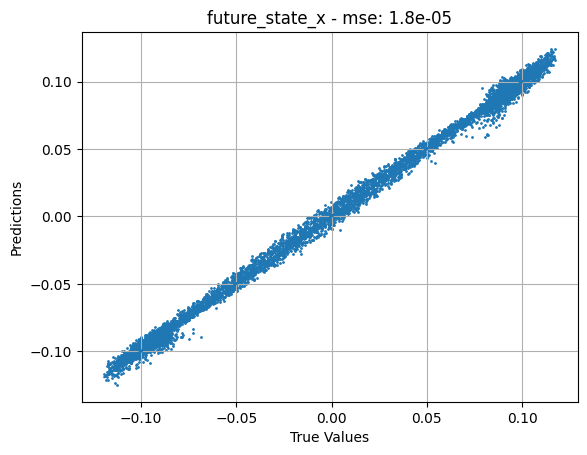

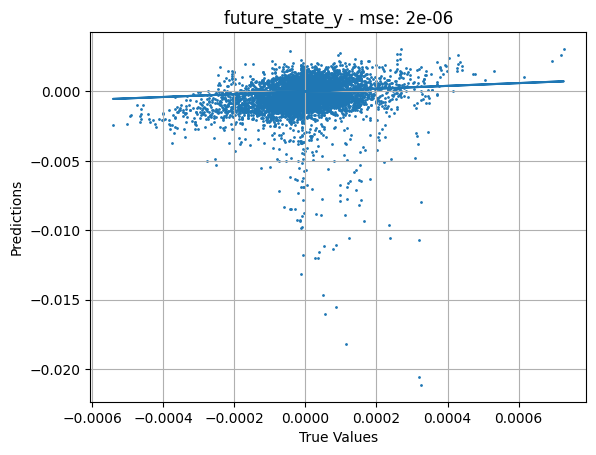

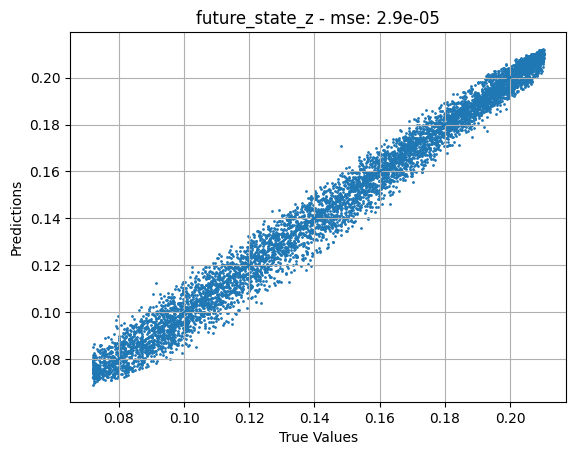

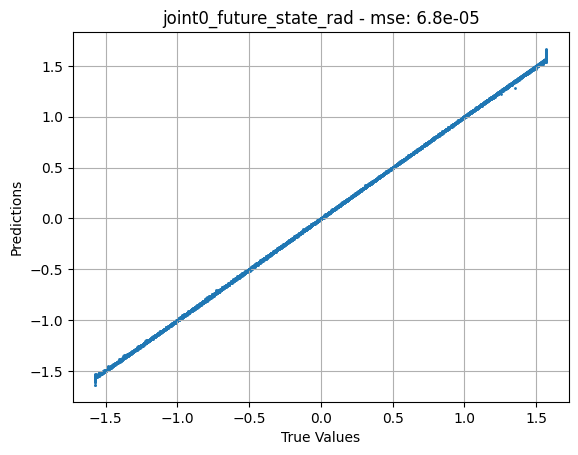

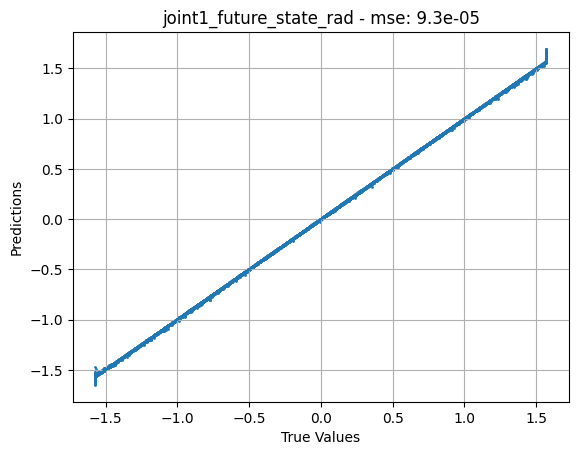

In [110]:
plot_pred_vs_test(y_test, df_test_predictions)

In [141]:
timestr = time.strftime("_%Y_%d_%m")
models_path = "models\\" + timestr[1:]
if not os.path.exists(models_path):
    os.mkdir(models_path)
    print(f"Directorio '{models_path}' ha sido creado.")
else:
    print(f"El directorio '{models_path}' ya existe.")
model.save(models_path + "\\model_" + scene + timestr + ".keras")
with open(models_path + "\\scaler_" + scene + timestr + '.pkl', 'wb') as file:
    pickle.dump(scaler, file)

Directorio 'models\2023_14_11' ha sido creado.


### Datos de entrenamiento

In [34]:
scene = "modular02_"
path = os.getcwd() + "\\training_data\\2023_14_11"
file_list = os.listdir(path)
scene_files_list = [item for item in file_list if scene in item and "pkl" in item]

print(scene_files_list[0])

file = open(path + "\\" + scene_files_list[0], "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)

joined_training_dataset_modular02_2023_14_11_1024.pkl


In [ ]:
## Se grafica la tabla de valores de entrenamiento para ver que tanto varian y si se tiene el rango necesario para la base.
columns = X_train.columns.tolist()
for col in range(-7,0):
    plt.figure()
    plt.scatter(X.iloc[:,col],training_df.iloc[:,1], s=1)
    plt.title(columns[col])
    plt.ylabel('Step')
    plt.xlabel(columns[col])
    #plt.xlim(-1,1)
    plt.grid()

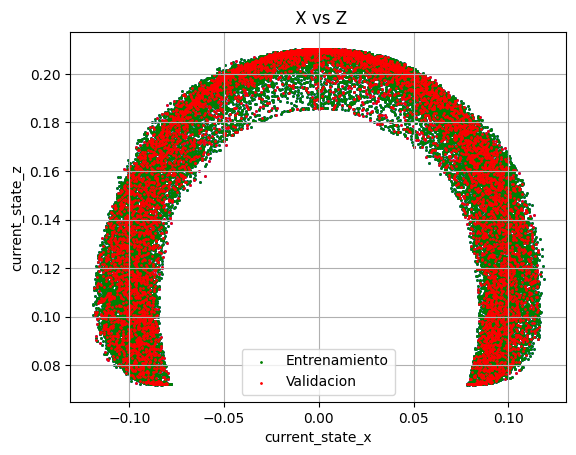

In [144]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,-7],X.iloc[:,-5], s=1, color='blue')
plt.scatter(X_train.iloc[:,-7],X_train.iloc[:,-5], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,-7],X_test.iloc[:,-5], s=1, color='red', label='Validacion')
plt.title(" X vs Z")
plt.ylabel(columns[-5])
plt.xlabel(columns[-7])
plt.legend()
plt.grid()

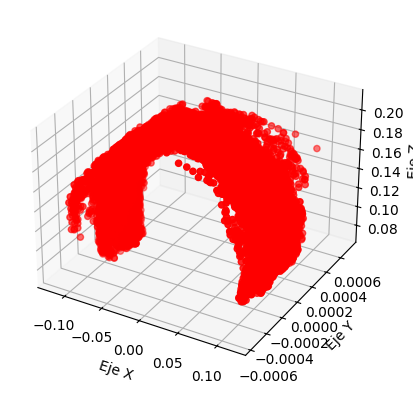

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos de ejemplo
x = X_train.iloc[:,-7]
y = X_train.iloc[:,-6]
z = X_train.iloc[:,-5]

# Crear una figura en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos en 3D
ax.scatter(x, y, z, c='r', marker='o')

# Etiquetas de ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Mostrar la gráfica en 3D
plt.show()

Se grafica para cada posicion del joint las acciones

In [118]:
X_train.columns.tolist()

['current_state_x',
 'current_state_y',
 'current_state_z',
 'joint0_current_state_rad',
 'joint1_current_state_rad',
 'joint0_actions_rad',
 'joint1_actions_rad']

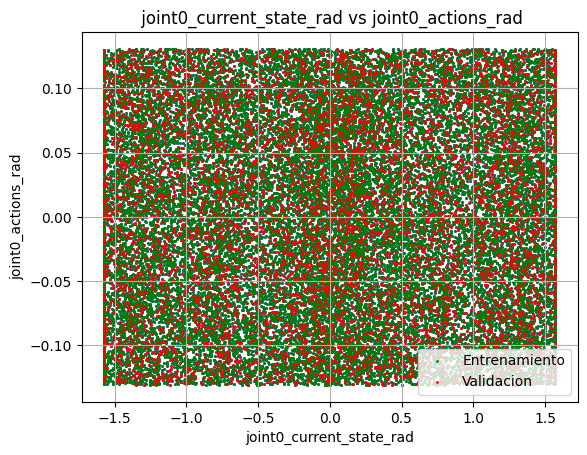

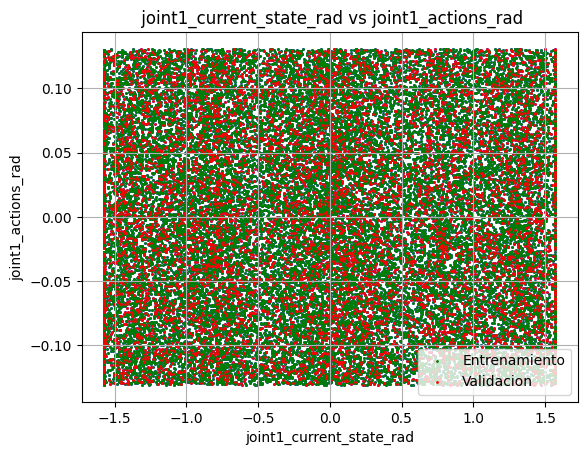

In [140]:
columns = X_train.columns.tolist()
joints_col = []
for col in columns:
    if "joint" in col:
        joints_col.append(col)
joints_col
joints_n = len(joints_col)//2
for joint in range(joints_n):
    plt.figure()
    state_col = 3 + joint
    act_col = 3 + joint + joints_n
    plt.scatter(X.iloc[:,state_col],X.iloc[:,act_col], s=1, color='blue')
    plt.scatter(X_train.iloc[:,state_col],X_train.iloc[:,act_col], s=1, color='green', label='Entrenamiento')
    plt.scatter(X_test.iloc[:,state_col],X_test.iloc[:,act_col], s=1, color='red', label='Validacion')
    plt.title(f" {columns[state_col]} vs {columns[act_col]}")
    plt.ylabel(columns[act_col])
    plt.xlabel(columns[state_col])
    plt.legend()
    plt.grid()